In [1]:
import cv2
import numpy as np
import os
from scipy import optimize
from matplotlib import pyplot as plt, cm, colors
from skimage import color
from skimage import io
from PIL import Image

In [2]:
# Get path to the current working directory
CWD_PATH = os.getcwd()

In [3]:
# FUNCTION TO READ AN INPUT IMAGE
def readVideo():

    # Read input video from current working directory
    inpImage = cv2.VideoCapture(os.path.join(CWD_PATH, 'video_2.mp4'))

    return inpImage

In [4]:
# Defining variables to hold meter-to-pixel conversion
ym_per_pix = 30 / 720
# Standard lane width is 3.7 meters divided by lane width in pixels which is
# calculated to be approximately 720 pixels not to be confused with frame height
xm_per_pix = 3.7 / 720

#### FUNCTIONS TO PERFORM IMAGE PROCESSING

In [5]:
def processImage(inpImage):

    # Apply HLS color filtering to filter out white lane lines
    hls = cv2.cvtColor(inpImage, cv2.COLOR_BGR2HLS)
    lower_white = np.array([0, 160, 10])
    upper_white = np.array([255, 255, 255])
    mask = cv2.inRange(inpImage, lower_white, upper_white)
    hls_result = cv2.bitwise_and(inpImage, inpImage, mask = mask)

    # Convert image to grayscale, apply threshold, blur & extract edges
    gray = cv2.cvtColor(hls_result, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY)
    blur = cv2.GaussianBlur(thresh,(3, 3), 0)
    canny = cv2.Canny(blur, 40, 60)

    # Display the processed images
    cv2.imshow("Image", inpImage)
    cv2.imshow("HLS Filtered", hls_result)
    cv2.imshow("Grayscale", gray)
    cv2.imshow("Thresholded", thresh)
    cv2.imshow("Blurred", blur)
    cv2.imshow("Canny Edges", canny)

    return image, hls_result, gray, thresh, blur, canny

#### FUNCTION TO APPLY PERSPECTIVE WARP

In [6]:
def perspectiveWarp(inpImage):

    # Get image size
    img_size = (inpImage.shape[1], inpImage.shape[0])

    # Perspective points to be warped
    src = np.float32([[590, 440],
                      [690, 440],
                      [200, 640],
                      [1000, 640]])

    # Window to be shown
    dst = np.float32([[200, 0],
                      [1200, 0],
                      [200, 710],
                      [1200, 710]])

    # Matrix to warp the image for birdseye window
    matrix = cv2.getPerspectiveTransform(src, dst)
    # Inverse matrix to unwarp the image for final window
    minv = cv2.getPerspectiveTransform(dst, src)
    birdseye = cv2.warpPerspective(inpImage, matrix, img_size)

    # Get the birdseye window dimensions
    height, width = birdseye.shape[:2]

    # Divide the birdseye view into 2 halves to separate left & right lanes
    birdseyeLeft  = birdseye[0:height, 0:width // 2]
    birdseyeRight = birdseye[0:height, width // 2:width]

    # Display birdseye view image
    cv2.imshow("Birdseye" , birdseye)
    cv2.imshow("Birdseye Left" , birdseyeLeft)
    cv2.imshow("Birdseye Right", birdseyeRight)

    return birdseye, birdseyeLeft, birdseyeRight, minv

In [7]:
image = readVideo()

while True:

    _, frame = image.read()
    # Apply perspective warping by calling the "perspectiveWarp()" function
    # Then assign it to the variable called (birdView)
    # Provide this function with:
    # 1- an image to apply perspective warping (frame)
    birdView, birdViewL, birdViewR, minverse = perspectiveWarp(frame)

    # Apply image processing by calling the "processImage()" function
    # Then assign their respective variables (img, hls, grayscale, thresh, blur, canny)
    # Provide this function with:
    # 1- an already perspective warped image to process (birdView)
    img, hls, grayscale, thresh, blur, canny = processImage(frame)
    imgL, hlsL, grayscaleL, threshL, blurL, cannyL = processImage(frame)
    imgR, hlsR, grayscaleR, threshR, blurR, cannyR = processImage(frame)
    if cv2.waitKey(1) == 13:
        break
    

AttributeError: 'NoneType' object has no attribute 'shape'

#### FUNCTION TO PLOT THE HISTOGRAM OF WARPED IMAGE

In [9]:
def plotHistogram(inpImage):

    histogram = np.sum(inpImage[inpImage.shape[0] // 2:, :], axis = 0)

    midpoint = np.int(histogram.shape[0] / 2)
    leftxBase = np.argmax(histogram[:midpoint])
    rightxBase = np.argmax(histogram[midpoint:]) + midpoint

    plt.xlabel("Image X Coordinates")
    plt.ylabel("Number of White Pixels")

    # Return histogram and x-coordinates of left & right lanes to calculate
    # lane width in pixels
    return histogram, leftxBase, rightxBase

In [10]:
#### START - APPLY SLIDING WINDOW METHOD TO DETECT CURVES ######################
def slide_window_search(binary_warped, histogram):

    # Find the start of left and right lane lines using histogram info
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # A total of 9 windows will be used
    nwindows = 9
    window_height = np.int(binary_warped.shape[0] / nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    #### START - Loop to iterate through windows and search for lane lines #####
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),
        (0,255,0), 2)
        cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high),
        (0,255,0), 2)
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    #### END - Loop to iterate through windows and search for lane lines #######

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Apply 2nd degree polynomial fit to fit curves
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

    ltx = np.trunc(left_fitx)
    rtx = np.trunc(right_fitx)
    plt.plot(right_fitx)
    plt.show()

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    plt.imshow(out_img)
    plt.plot(left_fitx,  ploty, color = 'yellow')
    plt.plot(right_fitx, ploty, color = 'yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

    return ploty, left_fit, right_fit, ltx, rtx
#### END - APPLY SLIDING WINDOW METHOD TO DETECT CURVES #

In [11]:
#### START - APPLY GENERAL SEARCH METHOD TO DETECT CURVES ######################
def general_search(binary_warped, left_fit, right_fit):

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) +
    left_fit[1]*nonzeroy + left_fit[2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) +
    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    ## VISUALIZATION ###########################################################

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    plt.imshow(result)
    plt.plot(left_fitx,  ploty, color = 'yellow')
    plt.plot(right_fitx, ploty, color = 'yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

    ret = {}
    ret['leftx'] = leftx
    ret['rightx'] = rightx
    ret['left_fitx'] = left_fitx
    ret['right_fitx'] = right_fitx
    ret['ploty'] = ploty

    return ret
#### END - APPLY GENERAL SEARCH METHOD TO DETECT CURVES ##

In [12]:
#### START - FUNCTION TO MEASURE CURVE RADIUS ##################################
def measure_lane_curvature(ploty, leftx, rightx):

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Fit new polynomials to x, y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad  = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')

    # Decide if it is a left or a right curve
    if leftx[0] - leftx[-1] > 60:
        curve_direction = 'Left Curve'
    elif leftx[-1] - leftx[0] > 60:
        curve_direction = 'Right Curve'
    else:
        curve_direction = 'Straight'

    return (left_curverad + right_curverad) / 2.0, curve_direction
#### END - FUNCTION TO MEASURE CURVE RADIUS ######

In [13]:
#### START - FUNCTION TO VISUALLY SHOW DETECTED LANES AREA #####################
def draw_lane_lines(original_image, warped_image, Minv, draw_info):

    leftx = draw_info['leftx']
    rightx = draw_info['rightx']
    left_fitx = draw_info['left_fitx']
    right_fitx = draw_info['right_fitx']
    ploty = draw_info['ploty']

    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    mean_x = np.mean((left_fitx, right_fitx), axis=0)
    pts_mean = np.array([np.flipud(np.transpose(np.vstack([mean_x, ploty])))])

    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    cv2.fillPoly(color_warp, np.int_([pts_mean]), (0, 255, 255))

    newwarp = cv2.warpPerspective(color_warp, Minv, (original_image.shape[1], original_image.shape[0]))
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)

    return pts_mean, result
#### END - FUNCTION TO VISUALLY SHOW DETECTED LANES AREA ####

In [14]:
#### START - FUNCTION TO CALCULATE DEVIATION FROM LANE CENTER ##################
################################################################################
def offCenter(meanPts, inpFrame):

    # Calculating deviation in meters
    mpts = meanPts[-1][-1][-2].astype(int)
    pixelDeviation = inpFrame.shape[1] / 2 - abs(mpts)
    deviation = pixelDeviation * xm_per_pix
    direction = "left" if deviation < 0 else "right"

    return deviation, direction
################################################################################
#### END - FUNCTION TO CALCULATE DEVIATION FROM LANE CENTER #####

In [15]:
#### START - FUNCTION TO ADD INFO TEXT TO FINAL IMAGE ##########################
def addText(img, radius, direction, deviation, devDirection):

    # Add the radius and center position to the image
    font = cv2.FONT_HERSHEY_TRIPLEX

    if (direction != 'Straight'):
        text = 'Radius of Curvature: ' + '{:04.0f}'.format(radius) + 'm'
        text1 = 'Curve Direction: ' + (direction)

    else:
        text = 'Radius of Curvature: ' + 'N/A'
        text1 = 'Curve Direction: ' + (direction)

    cv2.putText(img, text , (50,100), font, 0.8, (0,100, 200), 2, cv2.LINE_AA)
    cv2.putText(img, text1, (50,150), font, 0.8, (0,100, 200), 2, cv2.LINE_AA)

    # Deviation
    deviation_text = 'Off Center: ' + str(round(abs(deviation), 3)) + 'm' + ' to the ' + devDirection
    cv2.putText(img, deviation_text, (50, 200), cv2.FONT_HERSHEY_TRIPLEX, 0.8, (0,100, 200), 2, cv2.LINE_AA)

    return img
#### END - FUNCTION TO ADD INFO TEXT TO FINAL IMAGE 

In [16]:
image = readVideo()

KeyboardInterrupt: 

<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


306


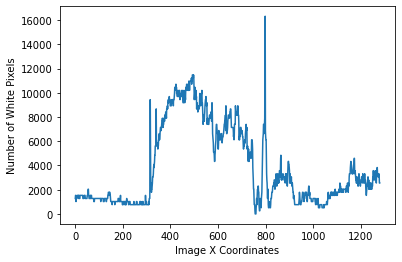

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

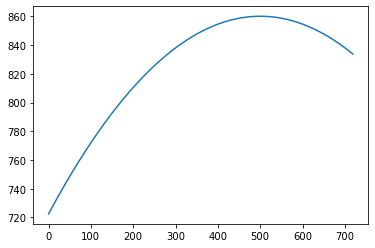

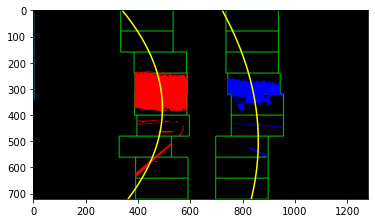

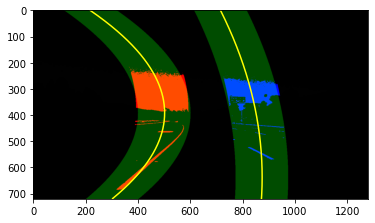

<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


360


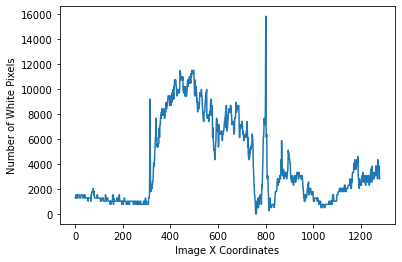

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

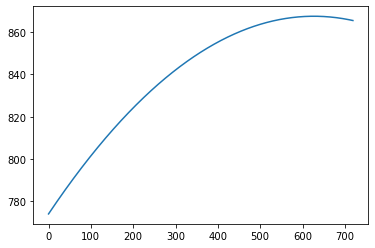

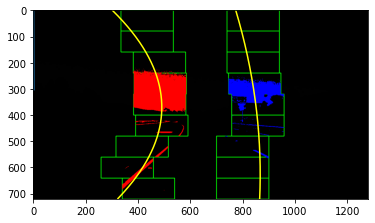

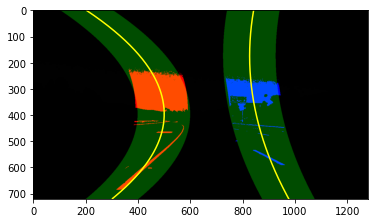

<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


384


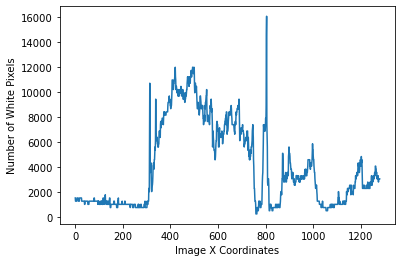

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

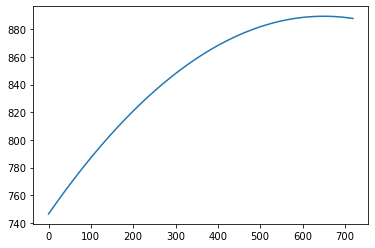

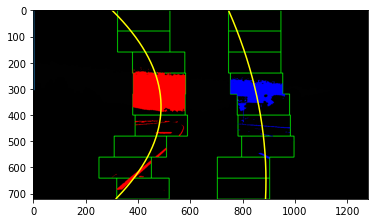

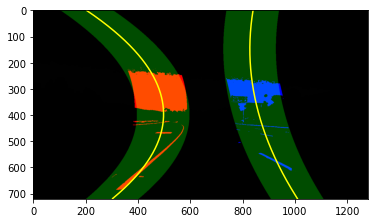

<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


312


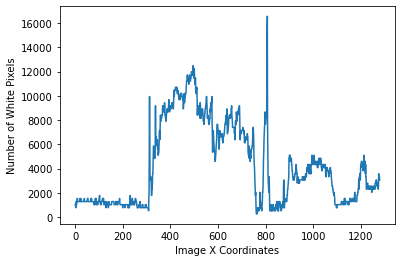

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

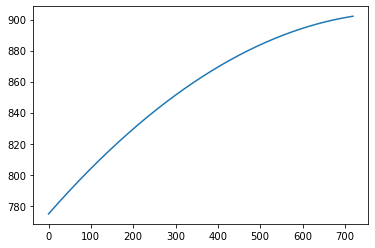

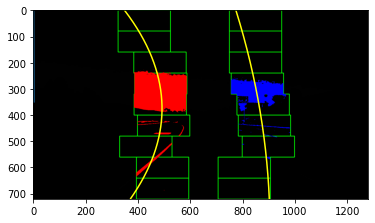

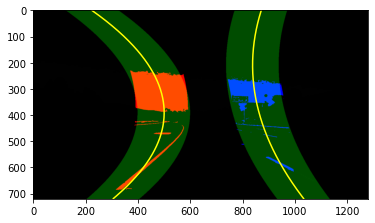

<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


316


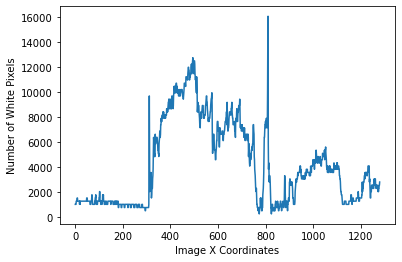

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

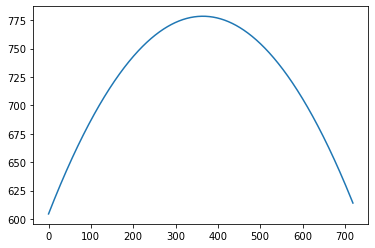

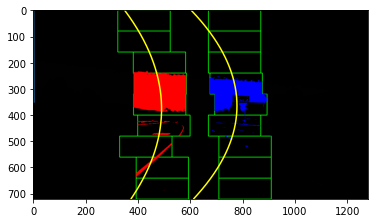

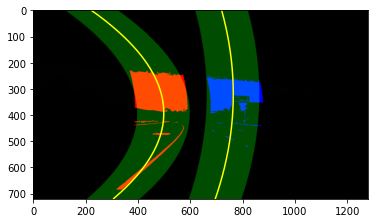

<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


312


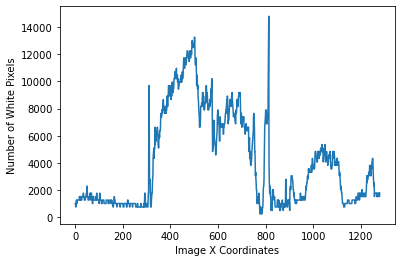

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

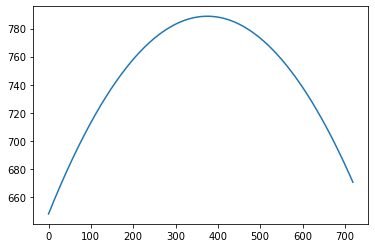

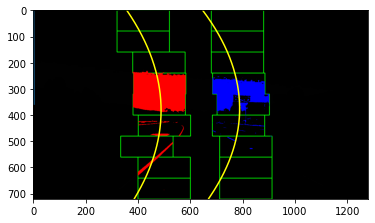

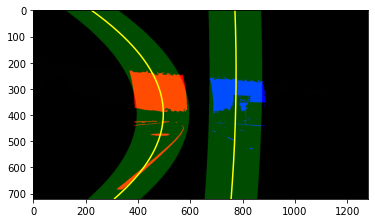

317


<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


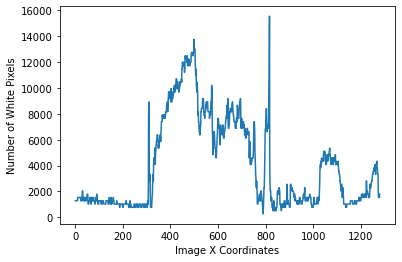

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

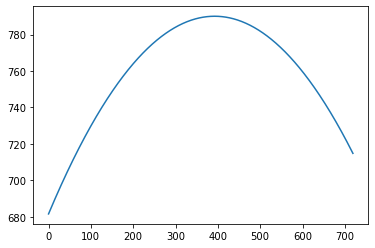

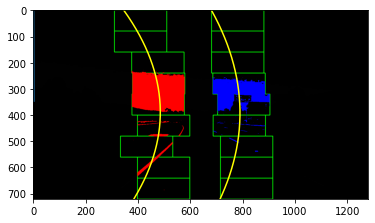

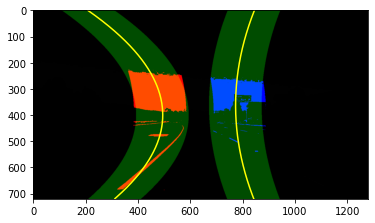

<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


319


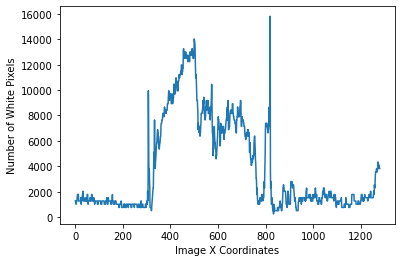

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

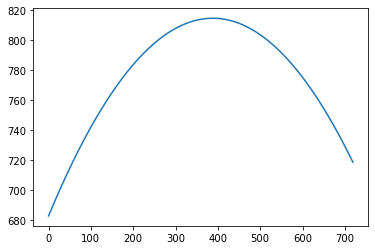

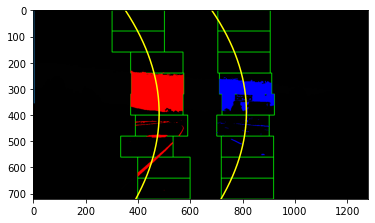

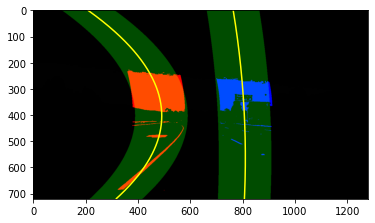

<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


332


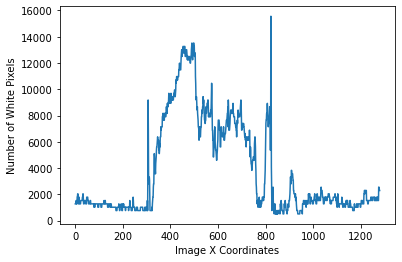

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

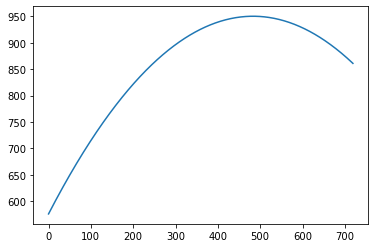

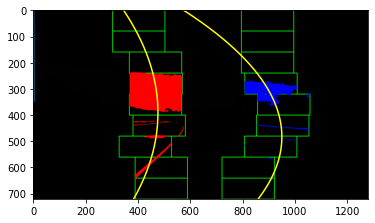

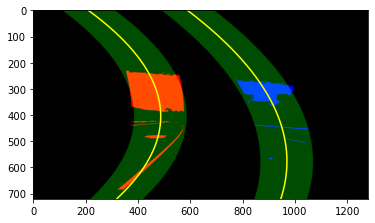

<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


374


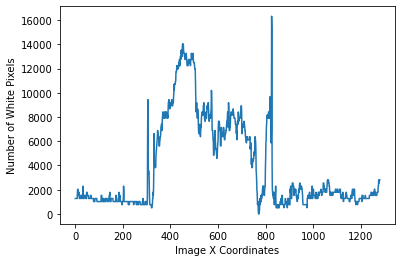

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

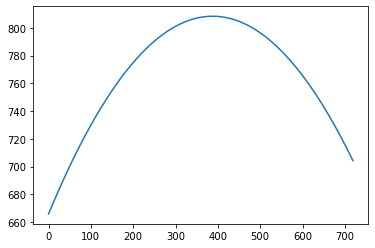

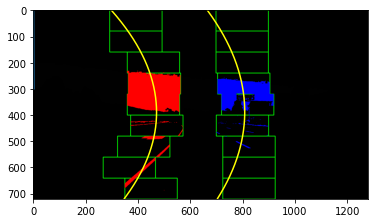

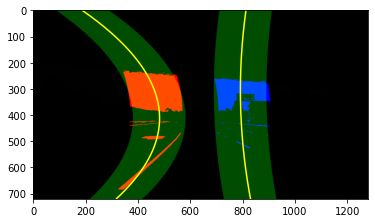

<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


376


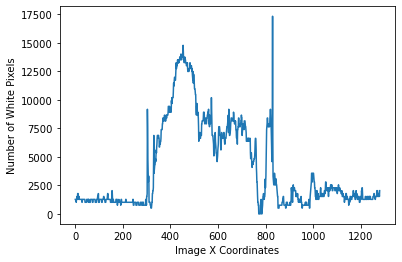

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

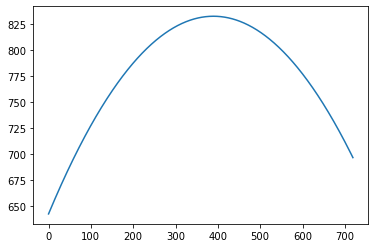

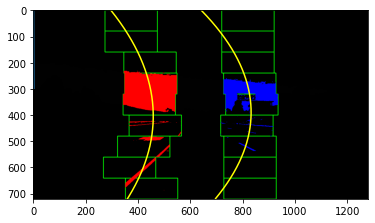

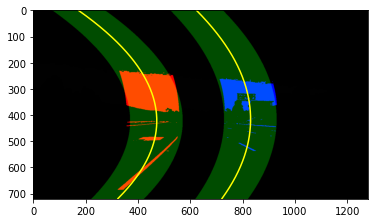

379


<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


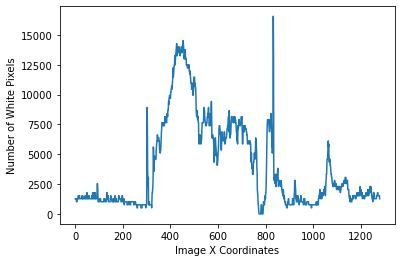

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

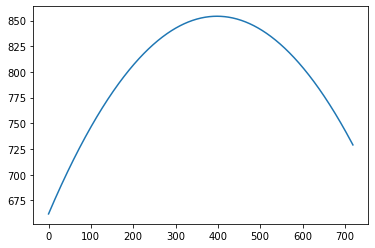

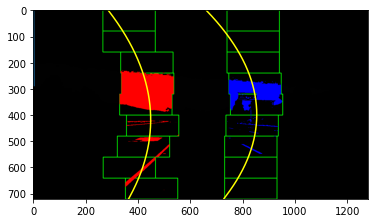

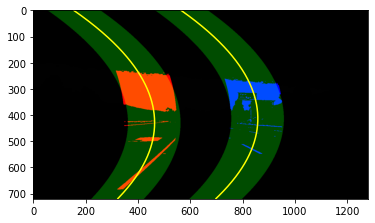

<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


412


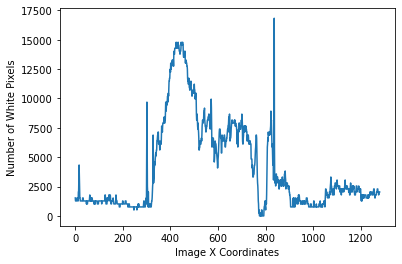

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

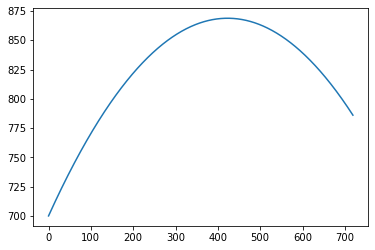

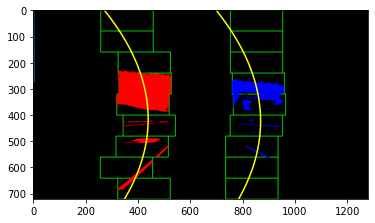

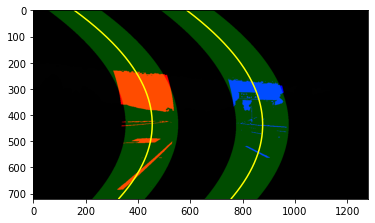

<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


416


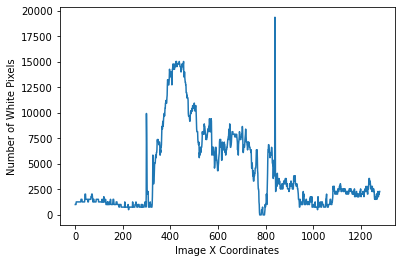

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

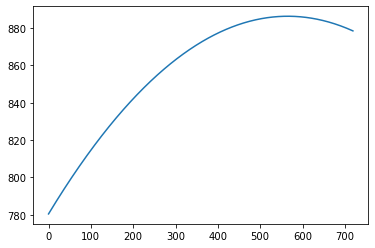

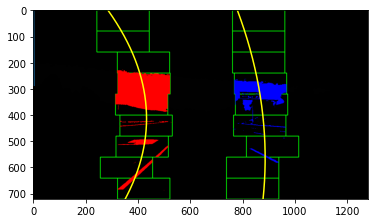

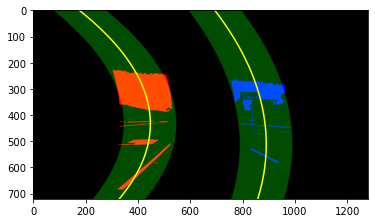

<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


405


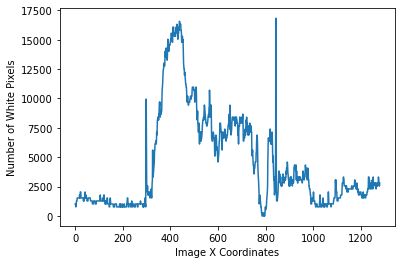

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

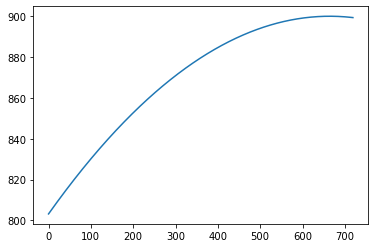

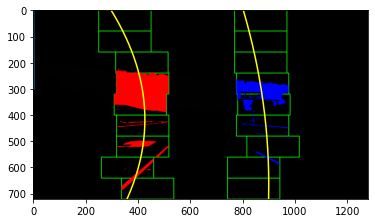

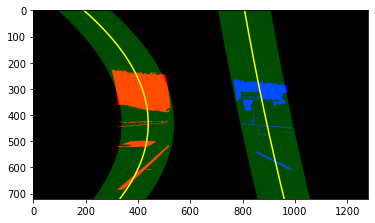

<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


436


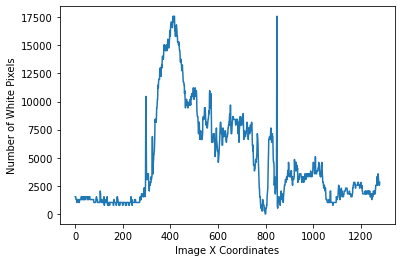

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

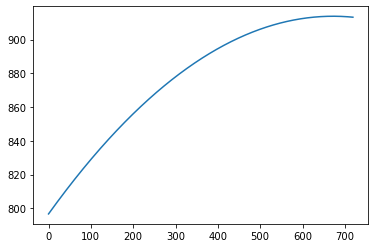

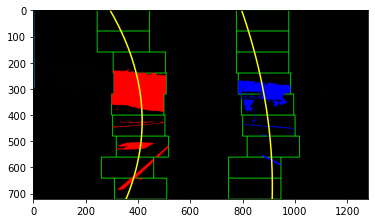

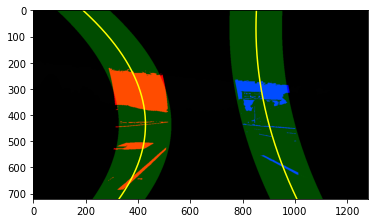

<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


444


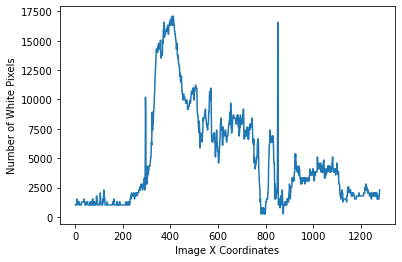

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

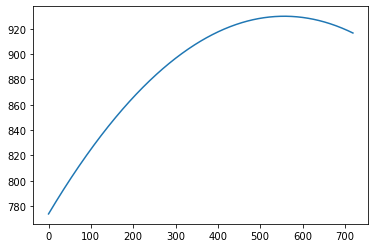

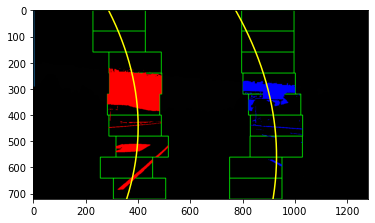

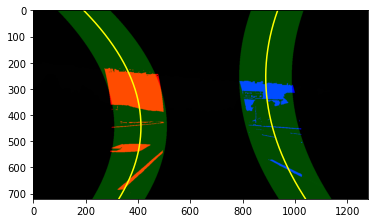

<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


469


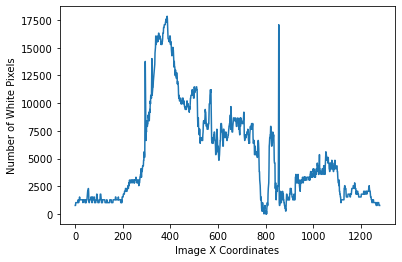

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

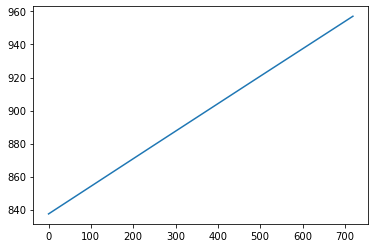

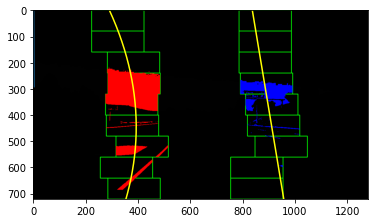

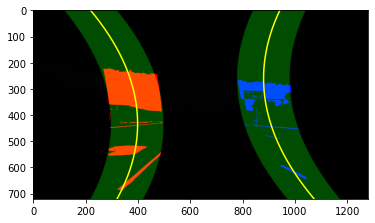

<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


566


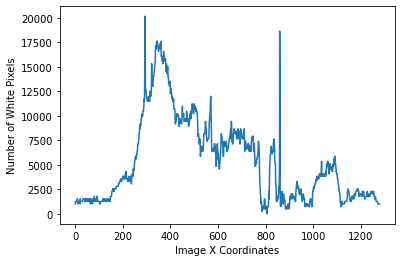

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

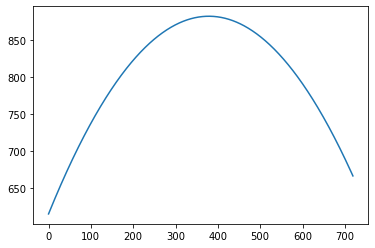

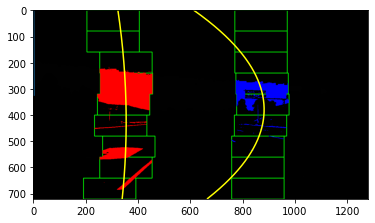

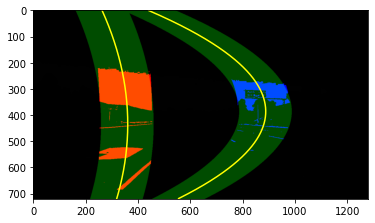

572


<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


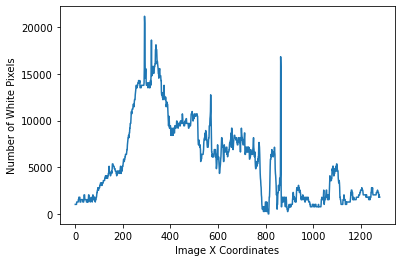

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

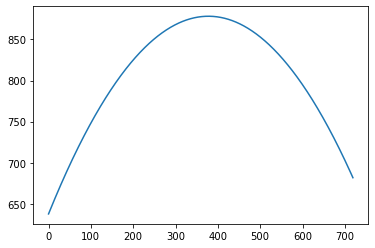

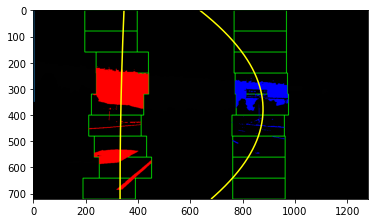

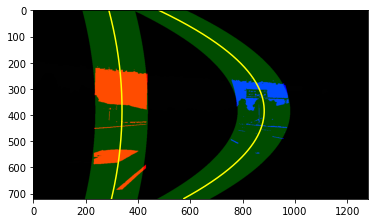

<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


578


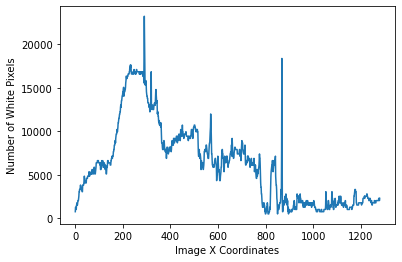

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

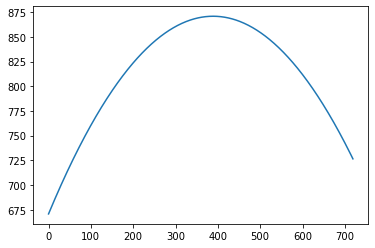

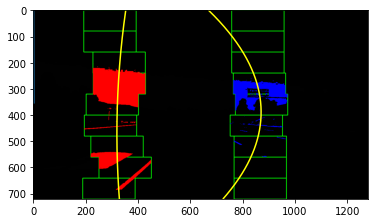

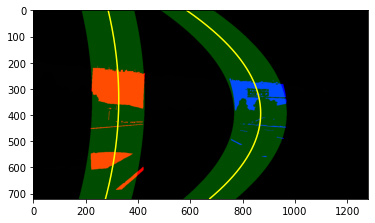

<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


680


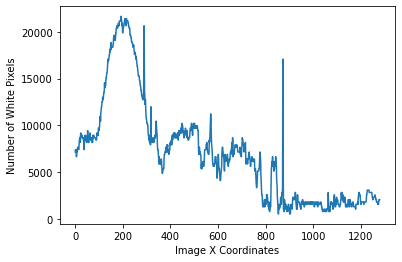

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

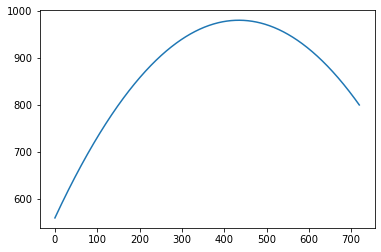

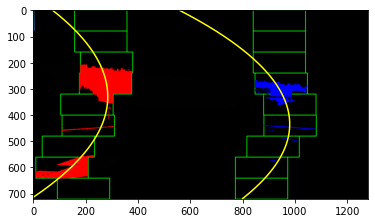

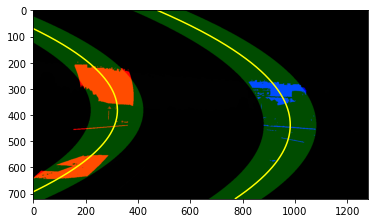

735


<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


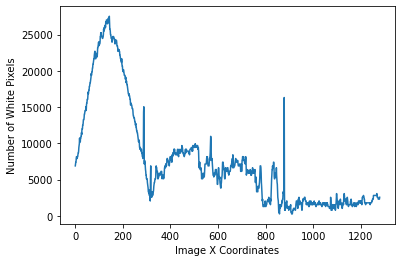

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

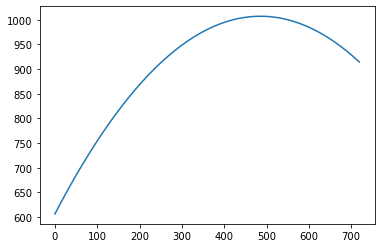

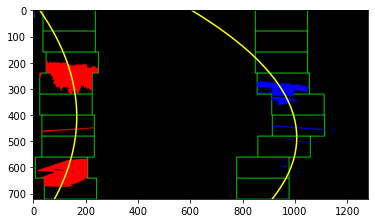

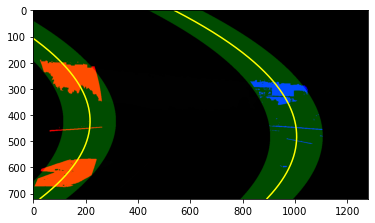

<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


761


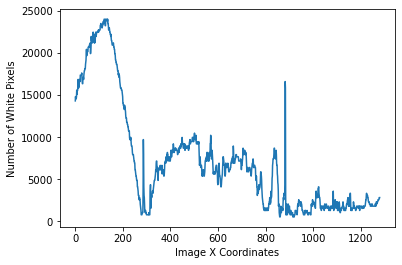

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

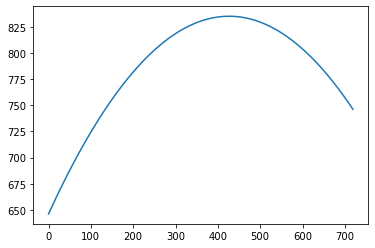

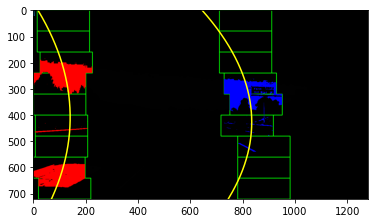

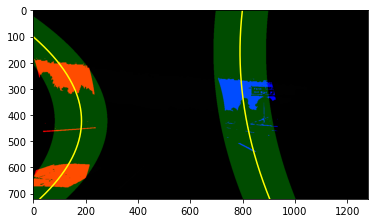

<ipython-input-8-d762c0bcbf0b>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)


809


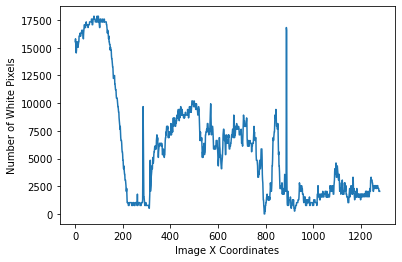

<ipython-input-9-050c7c42866a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
<ipython-input-9-050c7c42866a>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

In [16]:
#### START - LOOP TO PLAY THE INPUT IMAGE ######################################

while True:

    _, frame = image.read()
    # Apply perspective warping by calling the "perspectiveWarp()" function
    # Then assign it to the variable called (birdView)
    # Provide this function with:
    # 1- an image to apply perspective warping (frame)
    birdView, birdViewL, birdViewR, minverse = perspectiveWarp(frame)

    # Apply image processing by calling the "processImage()" function
    # Then assign their respective variables (img, hls, grayscale, thresh, blur, canny)
    # Provide this function with:
    # 1- an already perspective warped image to process (birdView)
    img, hls, grayscale, thresh, blur, canny = processImage(frame)
    imgL, hlsL, grayscaleL, threshL, blurL, cannyL = processImage(frame)
    imgR, hlsR, grayscaleR, threshR, blurR, cannyR = processImage(frame)

    # Plot and display the histogram by calling the "get_histogram()" function
    # Provide this function with:
    # 1- an image to calculate histogram on (thresh)
    hist, leftBase, rightBase = plotHistogram(thresh)
    print(rightBase - leftBase)
    plt.plot(hist)
    plt.show()

    ploty, left_fit, right_fit, left_fitx, right_fitx = slide_window_search(thresh, hist)
    plt.plot(left_fit)
    plt.show()

    draw_info = general_search(thresh, left_fit, right_fit)
    plt.show()

    curveRad, curveDir = measure_lane_curvature(ploty, left_fitx, right_fitx)

    # Filling the area of detected lanes with green
    meanPts, result = draw_lane_lines(frame, thresh, minverse, draw_info)

    deviation, directionDev = offCenter(meanPts, frame)

    # Adding text to our final image
    finalImg = addText(result, curveRad, curveDir, deviation, directionDev)

    # Displaying final image
    cv2.imshow("Final", finalImg)

    # Wait for the ENTER key to be pressed to stop playback
    if cv2.waitKey(1) == 13:
        break

#### END - LOOP TO PLAY THE INPUT IMAGE ########################################
################################################################################

# Cleanup
image.release()
cv2.destroyAllWindows()

################################################################################
######## END - MAIN FUNCTION ###

In [19]:

perspectiveWarp(image)

AttributeError: 'cv2.VideoCapture' object has no attribute 'shape'

In [21]:
processImage(frame)

(< cv2.VideoCapture 0000020FF61E76F0>,
 array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [201, 171, 183],
         ...,
         [205, 178, 176],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [229, 199, 211],
         ...,
         [228, 198, 197],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        ...,
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
   

: 